In [1]:
import aisdb
import nest_asyncio
from aisdb import DBQuery
from aisdb.database.dbconn import PostgresDBConn
from datetime import datetime
from PIL import ImageFile
from aisdb.weather.data_store import WeatherDataStore # for weather

nest_asyncio.apply()
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# >>> PostgreSQL Information <<<
db_user='<username>'            # DB User
db_dbname='aisviz'         # DB Schema
db_password='<password>'    # DB Password
db_hostaddr='127.0.0.1'    # DB Host address

dbconn = PostgresDBConn(
    port=5555,             # PostgreSQL port
    user=db_user,          # PostgreSQL username
    dbname=db_dbname,      # PostgreSQL database
    host=db_hostaddr,      # PostgreSQL address
    password=db_password,  # PostgreSQL password
)

In [33]:
xmin, ymin, xmax, ymax = -70, 45, -58, 53
gulf_bbox = [xmin, xmax, ymin, ymax]
start_time = datetime(2018, 8, 1)
end_time = datetime(2018, 8, 30)

qry = DBQuery(
    dbconn=dbconn,
    start=start_time, end=end_time,
    xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax,
    callback=aisdb.database.sqlfcn_callbacks.in_time_bbox_validmmsi
)

ais_tracks = []
rowgen = qry.gen_qry()
tracks = aisdb.track_gen.TrackGen(rowgen, decimate=True)

# Initialize WeatherDataStore Instance to work with Weather Grib Files from ERA5

In [4]:
# If you want to explicitely download weather data from CDS, set download_from_cds=True
weather_data_store = WeatherDataStore(short_names = ['10u','10v','tp'], start = start_time,end =  end_time,weather_data_path = ".",download_from_cds = False ,area = [-70, 45, -58, 53])

# If you already have the weather data downloaded, set download_from_cds=False, and specify path to the Grib files.
# weather_data_store = WeatherDataStore(short_names = ['10v','10u'],start = start_time,end = end_time,weather_data_path = "/home/CanadaV2",download_from_cds=True)

/home/vaishnav/vaishnav/Project11/AISdb/.venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/home/vaishnav/vaishnav/Project11/AISdb/.venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/home/vaishnav/vaishnav/Project11/AISdb/.venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False

In [34]:
from itertools import tee
tracks_with_weather = weather_data_store.yield_tracks_with_weather(tracks)
tracks_1, tracks_2,tracks_3,tracks_4 = tee(tracks_with_weather,4)

In [24]:
for t in tracks_1:
    print(f"'u-component' 10m wind for:\nlat: {t['lat'][0]} \nlon: {t['lon'][0]} \ntime: {t['time'][0]} \nis {t['weather_data']['10u'][0]} m/s")
    print(f"'v-component' 10m wind for:\nlat: {t['lat'][0]} \nlon: {t['lon'][0]} \ntime: {t['time'][0]} \nis {t['weather_data']['10v'][0]} m/s")
    print(f"'tp'  for:\nlat: {t['lat'][0]} \nlon: {t['lon'][0]} \ntime: {t['time'][0]} \nis {t['weather_data']['tp'][0][-1]} mm")
    break

'u-component' 10m wind for:
lat: 46.95649719238281 
lon: -64.77589416503906 
time: 1533132933 
is 2.166426658630371 m/s
'v-component' 10m wind for:
lat: 46.95649719238281 
lon: -64.77589416503906 
time: 1533132933 
is 1.5255718231201172 m/s
'tp'  for:
lat: 46.95649719238281 
lon: -64.77589416503906 
time: 1533132933 
is 2.384185791015625e-07 mm


# Plot Wind

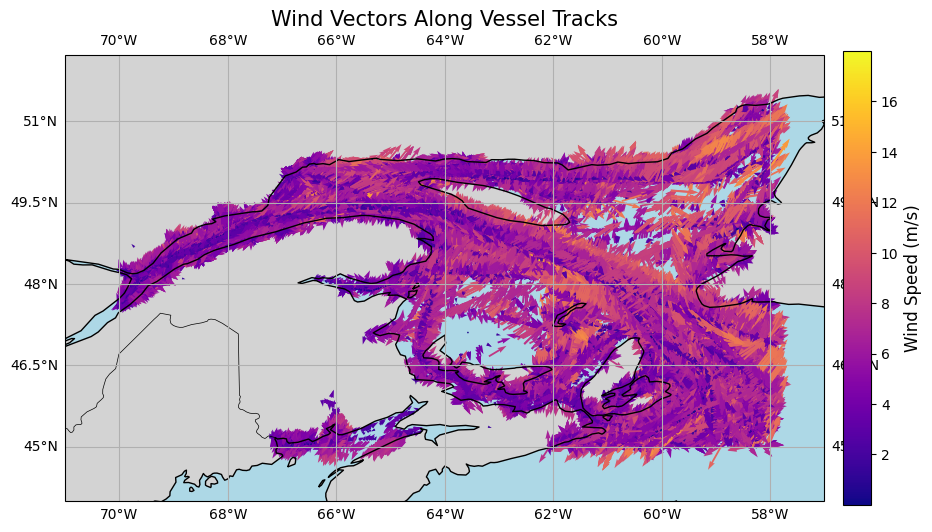

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Example input: tracks_with_weather (list of track dicts)
# Each track has: lat[], lon[], time[], weather_data['10u'][], weather_data['10v'][]

# ---------- Step 1: Flatten the data ----------
lats, lons, us, vs = [], [], [], []

for t in tracks_2:
    lats.extend(t['lat'])
    lons.extend(t['lon'])
    us.extend(t['weather_data']['10u'])
    vs.extend(t['weather_data']['10v'])

lats = np.array(lats)
lons = np.array(lons)
us = np.array(us)
vs = np.array(vs)
ws = np.sqrt(us**2 + vs**2)

# ---------- Step 2: Plot ----------
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map bounds based on track region (± buffer)
lat_min, lat_max = lats.min() - 1, lats.max() + 1
lon_min, lon_max = lons.min() - 1, lons.max() + 1
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

# Base map
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgray')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='lightblue')
ax.gridlines(draw_labels=True)

# Contour fill of wind speed (optional, if you have a surface)
# Else, we use only arrows here

# Wind direction arrows
qv = ax.quiver(lons, lats, us, vs, ws, scale=300, cmap='plasma', transform=ccrs.PlateCarree())
cb = plt.colorbar(qv, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label("Wind Speed (m/s)", fontsize=12)

plt.title("Wind Vectors Along Vessel Tracks", fontsize=15)
plt.tight_layout()
plt.show()


# Plotting Rainfall

/tmp/ipykernel_1496611/2459111073.py:12: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  timestamps.append(datetime.utcfromtimestamp(ts))


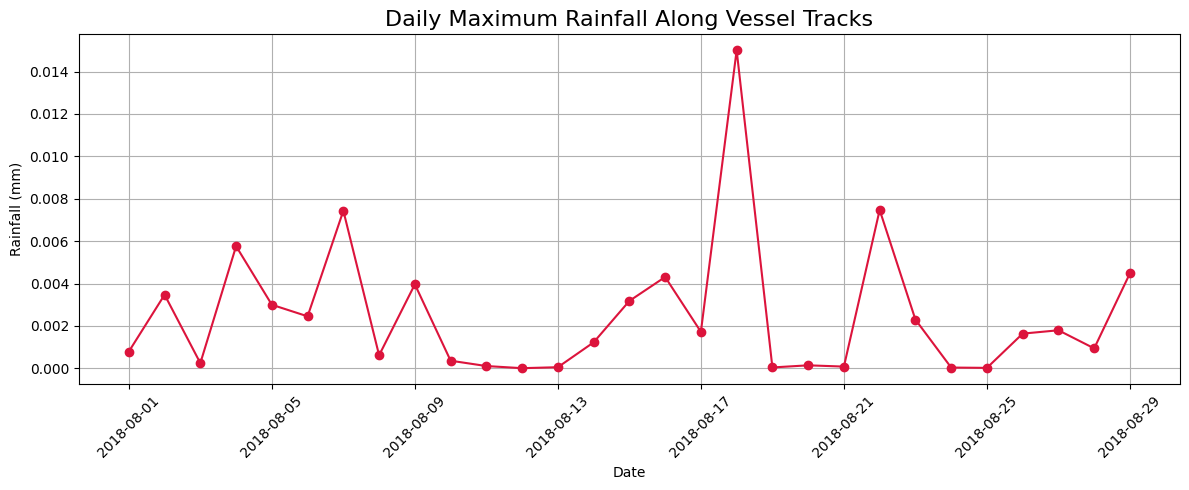

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

# ---------- Step 1: Extract timestamps and last value of tp ----------
timestamps = []
rainfall = []

for t in tracks_3:
    for ts, tp_series in zip(t['time'], t['weather_data']['tp']):
        timestamps.append(datetime.utcfromtimestamp(ts))
        rainfall.append(tp_series[-1])  # use last value

# ---------- Step 2: Convert to DataFrame and group by day ----------
df = pd.DataFrame({'timestamp': timestamps, 'rainfall': rainfall})
df['date'] = df['timestamp'].dt.date

# Take maximum rainfall per calendar day
daily_max = df.groupby('date')['rainfall'].max().reset_index()

# ---------- Step 3: Plot ----------
plt.figure(figsize=(12, 5))
plt.plot(daily_max['date'], daily_max['rainfall'], marker='o', linestyle='-', color='crimson')

plt.title("Daily Maximum Rainfall Along Vessel Tracks", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Remember to close the file

In [9]:
weather_data_store.close()

# Only download Weather Grib Files


In [ ]:
from aisdb.weather.weather_fetch import ClimateDataStore # for weather

climateDataStore = ClimateDataStore(dataset="reanalysis-era5-single-levels", short_names= ['10v','10u'], start_time = start_time, end_time = end_time, area= gulf_bbox)
climateDataStore.download_grib_file(output_folder="/weather_data")

2025-05-13 15:14:41,225 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-13 15:14:41,227 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
[2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
Processing 2023-8: Last day is 31
Final request parameters: {'product_type': ['reanalysis'], 'data_format': 'grib', 'download_format': 'unarchived', 'area': [53, -70, 

Error while fetching weather data: [Errno 13] Permission denied: '/weather_data'
